# PATE GAN based on DCGAN

We will attempt to employ sophisticated tecniques of PATE GANs

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
n_teachers = 10

In [3]:
import os

GDRIVE_PATH = ''
THIS_EXERCISE_PATH = os.path.join(GDRIVE_PATH, "GAN_exercises")
MODELS_HOME = os.path.join(THIS_EXERCISE_PATH, "mnist guns")

In [35]:
GENERATOR_FILE = os.path.join(MODELS_HOME, 'generator_pate.pt')
DISCRIMINATOR_FILE = os.path.join(MODELS_HOME, 'student_pate.pt')
TEACHERS_FILE = [os.path.join(MODELS_HOME, 'teacher_pate_' + str(i) + '.pt') for i in range(n_teachers)]
#TODO teacher's files - ?

In [5]:
os.makedirs(THIS_EXERCISE_PATH, exist_ok=True)
os.makedirs(MODELS_HOME, exist_ok=True)

In [6]:
class Reshape(torch.nn.Module):
  """
  Reshapes a tensor starting from the 1st dimension (not 0th),
  i. e. without influencing the batch dimension.
  """
  def __init__(self, *shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(x.shape[0], *self.shape)
  
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

# Load data

In [7]:
LEAK_SHARE = 0.2 #how much elements have been delivered to an adversary

In [8]:
import pandas as pd

In [9]:
df = pd.read_csv('https://query.data.world/s/nap7jvxtupud25z5ljvtbzzjjsqqay')
df.head()

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_774,column_775,column_776,column_777,column_778,column_779,column_780,column_781,column_782,column_783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
target = pd.read_csv('https://query.data.world/s/sn3dximsq5sw3a6wtqoc3okulevugz')
target.head()

,column_0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [11]:
from sklearn.model_selection import train_test_split
train, test, tar_train, tar_test = train_test_split(df, target, test_size=0.2, random_state=12345)

In [12]:
train = np.array(train, dtype='float')
test = np.array(test, dtype='float')
tar_train = np.array(tar_train, dtype='float')
tar_test = np.array(tar_test, dtype='float')

train= train.reshape((-1, 1, 28, 28)) / 255.
test= test.reshape((-1, 1, 28, 28)) / 255.

In [13]:
n_leak = round(LEAK_SHARE * train.shape[0])
train_leak = train[np.random.permutation(train.shape[0])]
train_check = train_leak[n_leak:]
train_leak = train_leak[0:n_leak]

# The net itself

Generator (the only one) with a discriminator as the student.

In [14]:
CODE_SIZE = 100
DROPOUT_RATE = 0.2
nc=1
nz=100
ngf=64
ndf=64

try:
  generator = torch.load(GENERATOR_FILE)
  discriminator = torch.load(DISCRIMINATOR_FILE)
except FileNotFoundError:
  print('Files have not been not found: making new nets\n')
  generator = torch.nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf,nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        ).cuda()

  student = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            #nn.Sigmoid()
        ).cuda()

Files have not been not found: making new nets



Several teachers.

In [15]:
teacher = []

In [16]:
for i in range(n_teachers):
    teacher.append(nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            #nn.Sigmoid()
        ).cuda())

In [73]:
#pred is teacher's prediction: 2d array: pred[i][0] - likelihood of fake, pred[i][1] = 1 - pred[i][0] - likelihood of real
def PATE(lam, pred):
    return (pred.sum(axis=0) + \
                     np.random.exponential(1/lam, (pred.shape[1])) - \
                     np.random.exponential(1/lam, (pred.shape[1]))) <  \
              (n_teachers - pred.sum(axis=0) + \
                     np.random.exponential(1/lam, (pred.shape[1])) - \
                     np.random.exponential(1/lam, (pred.shape[1])))

In [17]:
EPSILON = 0.01
lam = train.shape[0] / EPSILON #see page 4, there is a theorem

In [18]:
def sample_fake(batch_size):
  noise = torch.randn(batch_size, CODE_SIZE, 1, 1, device="cuda")
  return generator(noise)

### Train set division

In [19]:
train_teach = train.reshape((10, -1, 1, 28, 28)) #train set division

In [20]:
train.shape

(56000, 1, 28, 28)

In [21]:
train_teach.shape

(10, 5600, 1, 28, 28)

In [40]:
def sample_images_for_teacher(batch_size, num):
    ids = np.random.choice(len(train_teach[num]), size=batch_size)
    return torch.tensor(train_teach[num, ids], device="cuda").float()

In [23]:
def sample_images(batch_size, train=train):
  ids = np.random.choice(len(train), size=batch_size)
  return torch.tensor(train[ids], device="cuda").float()

### Losses (?) 

In [76]:
from torch.nn.functional import logsigmoid
from torch.nn.functional import sigmoid

def generator_loss(fake):
    return logsigmoid(-student(
              fake
          )).mean() #log(1 - sigmoid(student_prediction))
  
def student_loss(fake, pred):
    r = torch.tensor(PATE(lam, pred), device = 'cuda').float()
    
    return (r * logsigmoid(student(fake))).mean() + \
          ((1-r)*logsigmoid(-student(fake))).mean()

def teacher_loss(real, fake, num):
    return -logsigmoid(teacher[num](
              real
          )).mean() - \
          logsigmoid(-teacher[num](
              fake
          )).mean()



In [62]:
optimizer_generator = \
    torch.optim.RMSprop(generator.parameters(), lr=1e-3)
optimizer_student = \
    torch.optim.RMSprop(student.parameters(), lr=1e-3)

student_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_student, step_size=10, gamma=0.999)
gen_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_generator, step_size=10, gamma=0.999)
#TODO teacher optimisers - ???
optimizer_teacher = []
teacher_scheduler = []
for i in range(n_teachers):
    optimizer_teacher.append(torch.optim.RMSprop(teacher[i].parameters(), lr=0.001))
    teacher_scheduler.append(torch.optim.lr_scheduler.StepLR(optimizer_teacher[i], step_size=10, gamma=0.999))

In [78]:
def gen_train():
    fake = sample_fake(BATCH_SIZE)
    gen_loss = generator_loss(fake)
    optimizer_generator.zero_grad()
    gen_loss.backward()
    optimizer_generator.step()
    return gen_loss

def teacher_train(num):
    real = sample_images_for_teacher(BATCH_SIZE, num)
    fake = sample_fake(BATCH_SIZE)
    tea_loss = teacher_loss(real, fake, num)
    optimizer_teacher[num].zero_grad()
    tea_loss.backward()
    optimizer_teacher[num].step()
    return tea_loss

def student_train():
    fake = sample_fake(BATCH_SIZE)
    pred = np.array([(sigmoid(teacher[i](fake))).cpu().detach().numpy() for i in range(n_teachers)])
    stud_loss = student_loss(fake, pred)
    optimizer_student.zero_grad()
    stud_loss.backward()
    optimizer_student.step()
    return stud_loss

In [64]:
VALIDATION_INTERVAL = 150
SAVE_INTERVAL = 500
NT = 5
NS = 5
BATCH_SIZE=64

In [86]:
import matplotlib

def plot_images(images: np.ndarray,
                nrows: int=5, ncols: int=5,
                shuffle: bool=True,
                title: str="",
                figure: matplotlib.figure.Figure=None) -> matplotlib.figure.Figure:
  """
  Plots a subset of images.
  
  Args:
    images[n_images, n_channels, width, height]: a dataset with images to plot
    nrows: number of images in a plotted row
    ncols: numer of images in a plotted colunm
    shuffle: if True draw a random subset of images, if False -- the first ones
    figure: if not None, it's used for plotting, if None, a new one is created
  
  Returns:
    a figure containing the plotted images
  """
  if shuffle:
    images_to_plot = images[np.random.permutation(len(images))[:nrows*ncols]]
  else:
    images_to_plot = images[:nrows * ncols]
  h, w = images_to_plot.shape[2:]
  if figure is None:
    figure = plt.figure(figsize=(8,8))
  
  axes = figure.subplots(nrows=nrows, ncols=ncols)
  for row_idx, ax_row in enumerate(axes):
    for col_idx, ax in enumerate(ax_row):
      ax.imshow(images_to_plot[row_idx + ncols*col_idx, 0],
                interpolation="none")
      ax.set_axis_off()

  figure.suptitle(title, fontsize=18)
  return figure

#plot_images(train, title="Some digits");

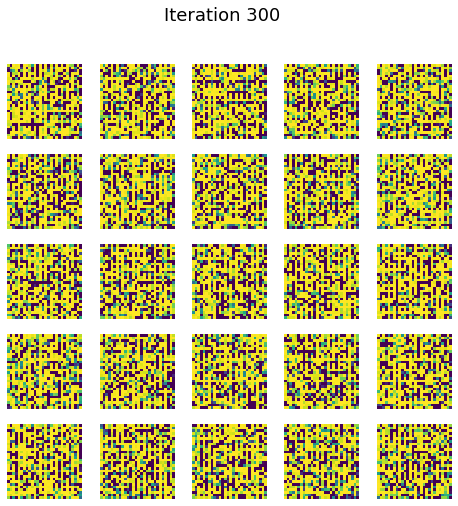

In [ ]:
from IPython.display import clear_output
for i in range(2000):
    # Set our models to training mode:
    generator.train()
    student.train()
    gen_scheduler.step()
    student_scheduler.step()
    for num in range(n_teachers):
        teacher[num].train()
        teacher_scheduler[num].step()
        
  
  # Several discriminator updates per step:
    for j in range(NT):
        for k in range(n_teachers):
            # Sampling reals and fakes
            teacher_train(k)
    
    for j in range(NS):
        student_train()
        
    gen_train()

    if i % SAVE_INTERVAL == 0:
        torch.save(generator, GENERATOR_FILE)
        torch.save(student, DISCRIMINATOR_FILE)
        for num in range(n_teachers):
            torch.save(teacher[num], TEACHERS_FILE[num])

    if i % VALIDATION_INTERVAL == 0:
        clear_output(wait=True)
        generator.eval()
        imgs = sample_fake(25).cpu().detach().numpy()
        plot_images(imgs.clip(0, 1), title='Iteration '+str(i));
        plt.show();

In [56]:
fake = sample_fake(BATCH_SIZE)
pred = np.array([(sigmoid(teacher[i](fake))).cpu().detach().numpy() for i in range(n_teachers)])
    

In [57]:
fake.shape

torch.Size([64, 1, 28, 28])

In [58]:
pred.shape

(10, 64, 1, 1, 1)